# NBA Player Anaysis and Clustering
## Brody Coyne
### 12/16/2022

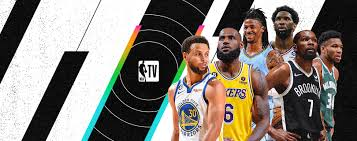

Since getting into the NBA and basketball in general years ago I have always liked to look at player stats. Being able to compare players, especially on the teams I root for, is very interesting to me because it helps to give a more definitive look into how well players are playing. Seeing all of the recorded stats in the table below is very cool to me and all of the many different options interests me.

The main goal for the end of my report is to cluster the different NBA players based off of their stats. I would assume that players would be clustered primarily based on their positions, play styles, and their talent level. I want to see if my assumptions are correct.

When coming up with the idea to cluster NBA players, I came up with the idea myself without looking online. But I wanted to look up other similar projects to see what has already been done and if there are any new insights I may want to provide. The project that is the most similar to mine is this one. https://towardsdatascience.com/redefining-nba-player-classifications-using-clustering-36a348fa54a8 In his project he uses more advanced analytics. I want to keep my project more simple to make it easier to understand for a larger audience. 

In [64]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import json
import base64
import requests

from sklearn.cluster import KMeans
import os

In [65]:
nbadata = pd.read_csv("nbadatadec07.csv")

Data source:https://www.basketball-reference.com/leagues/NBA_2023_per_game.html
This data comes from Basketball Reference and it has every single NBA player that has recorded a statistic. It has a significant amount of different statistics that it collects. Even though I won't use a lot of the stats in my analysis it is helpful to have so many options.

In [66]:
nbadata

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS▼,Player-additional
0,1,Luka Dončić,PG,23,DAL,23,23,36.8,11.3,22.4,...,0.8,7.7,8.6,8.7,1.7,0.7,3.7,2.9,32.9,doncilu01
1,2,Giannis Antetokounmpo,PF,28,MIL,19,19,32.9,11.7,21.6,...,2.1,9.3,11.3,5.5,0.8,1.1,3.7,3.4,31.9,antetgi01
2,3,Joel Embiid,C,28,PHI,16,16,35.3,10.4,20.2,...,1.6,7.9,9.6,4.9,1.1,1.8,4.1,3.3,31.9,embiijo01
3,4,Shai Gilgeous-Alexander,SG,24,OKC,22,22,35.7,10.7,21.1,...,1.0,3.8,4.8,6.0,1.8,1.1,3.3,2.5,31.3,gilgesh01
4,5,Jayson Tatum,PF,24,BOS,24,24,37.0,10.1,21.0,...,1.1,7.2,8.3,4.2,1.0,1.0,2.8,2.3,30.8,tatumja01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,477,Cody Martin,SF,27,CHO,1,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,martico01
477,478,Trevelin Queen,PG,25,IND,2,0,10.0,0.0,1.5,...,0.5,1.0,1.5,1.0,0.5,0.5,1.5,0.5,0.0,queentr01
478,479,Dereon Seabron,SG,22,NOP,2,0,1.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,seabrde01
479,480,Marko Simonovic,C,23,CHI,1,0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,simonma01


Before clustering I wanted to look at some specific elements of the data to help me get a better understanding of the data as a whole.

I wanted to see the breakdown by positions. I was surprised that the most common position in the NBA is a shooting guard, if anything I would have expected that it would be the least common. I also thought there would be more point guards and centers.

In [67]:
position_counts = nbadata.groupby('Pos').size()[['PG', 'SG', 'SF', 'PF', 'C']]
position_counts_df = position_counts.reset_index()
position_counts_df = position_counts_df.rename(columns={0: 'Count'})
position_counts_df


,Pos,Count
0,PG,92
1,SG,123
2,SF,83
3,PF,103
4,C,80


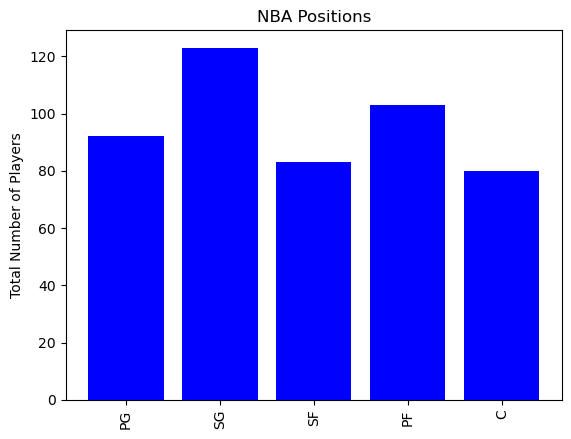

In [68]:
fig, ax1 = plt.subplots()
position_counts_bar = position_counts_df['Count']
position_counts_df_name = position_counts_df['Pos']
ax1.bar(position_counts_df_name,position_counts_bar, color = 'blue')
plt.xticks(rotation=90)

ax1.set_title('NBA Positions')
ax1.set_ylabel('Total Number of Players')

plt.show()

I wanted to look for the average values for both assists and rebounds. This is because I think that both of these values will play a large role in clustering, because generally point guards will have more assists and taller positions like power forwards and centers will have more rebounds.

In [69]:
grouped_players = nbadata.groupby('Pos')
grouped_players['TRB'].mean()

Pos
C     5.356250
PF    4.357282
PG    2.655435
SF    3.027711
SG    2.621138
Name: TRB, dtype: float64

In [70]:
grouped_players['AST'].mean()

Pos
C     1.273750
PF    1.588350
PG    3.644565
SF    1.501205
SG    1.996748
Name: AST, dtype: float64

Because I believe that assists and rebounds will play a large role in clustering the players, I first wanted to isolate those two factors to better visualize the difference between the positions. The results were pretty expected with the point guards having higher assist numbers and the centers having higher rebound numbers.

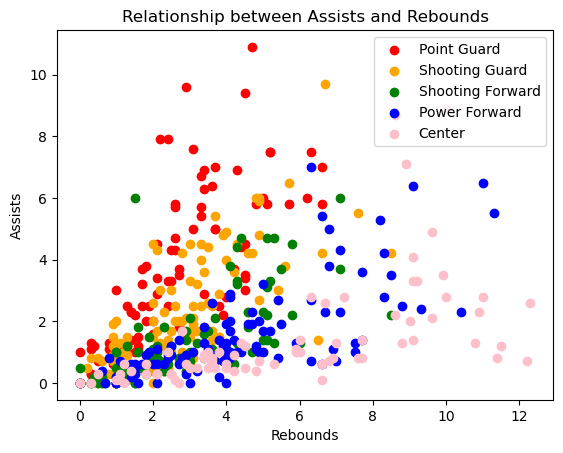

In [71]:
pos_pg = nbadata.query("Pos == 'PG'")
pos_sg = nbadata.query("Pos == 'SG'")
pos_sf = nbadata.query("Pos == 'SF'")
pos_pf = nbadata.query("Pos == 'PF'")
pos_c = nbadata.query("Pos == 'C'")

fig1, ax1 = plt.subplots()
ax1.scatter(pos_pg['TRB'], pos_pg['AST'], label = "Point Guard", color = 'red')
ax1.scatter(pos_sg['TRB'], pos_sg['AST'], label = "Shooting Guard", color = 'orange' )
ax1.scatter(pos_sf['TRB'], pos_sf['AST'], label = "Shooting Forward", color = 'green')
ax1.scatter(pos_pf['TRB'], pos_pf['AST'], label = "Power Forward", color = 'blue')
ax1.scatter(pos_c['TRB'], pos_c['AST'], label = "Center", color = 'pink')

ax1.set_xlabel('Rebounds')
ax1.set_ylabel('Assists')
ax1.set_title('Relationship between Assists and Rebounds')
ax1.legend()
plt.show()

The distribution of points per game scoring.

Text(0, 0.5, 'Number of Players')

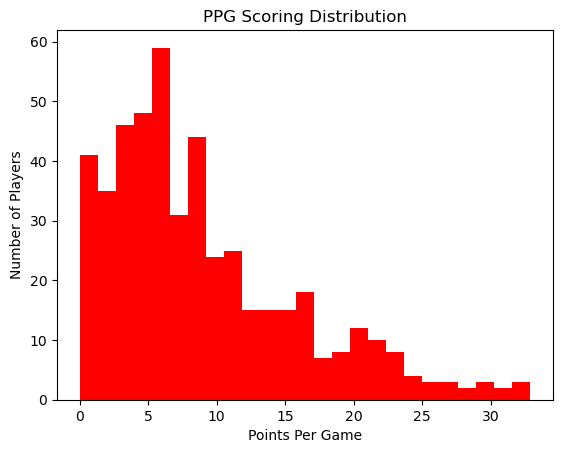

In [72]:
fig, ax1 = plt.subplots()
nba_dat_hist = nbadata['PTS▼']
ax1.hist(nba_dat_hist, bins = 25, color = 'red')
ax1.set_title('PPG Scoring Distribution')
ax1.set_xlabel('Points Per Game')
ax1.set_ylabel('Number of Players')

The distribution of 3 point percentage.

Text(0, 0.5, 'Number of Players')

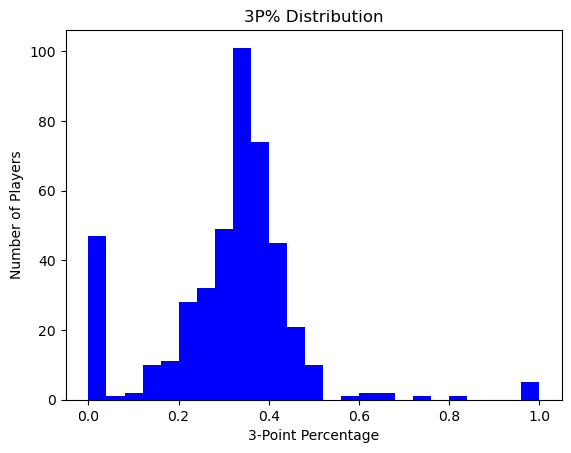

In [73]:
fig, ax1 = plt.subplots()
nba_dat_hist = nbadata['3P%']
ax1.hist(nba_dat_hist, bins = 25, color = 'blue')
ax1.set_title('3P% Distribution')
ax1.set_xlabel('3-Point Percentage')
ax1.set_ylabel('Number of Players')

In [74]:
os.environ['OMP_NUM_THREADS'] = '2'
print(os.environ['OMP_NUM_THREADS'])

2


In order to create a visualization of the clustering I had to first use kmeans clustering. After that I created a scatter plot which includes data points for all of the players. Since there are so many players I didn't want to include all of the names because too many of them would overlap. For that reason I decided to only show the names of the players that either had more than 12 points or more than 5 rebounds.

C:\Users\brody\anaconda3\envs\data-fa22\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


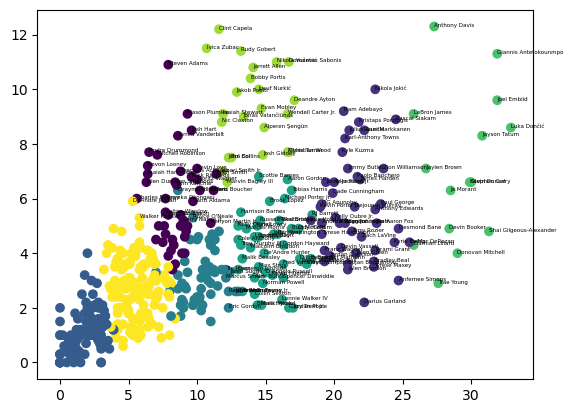

In [75]:
features = ['PTS▼', 'TRB', 'AST', 'STL', 'BLK']
kmeans = KMeans(n_clusters=8)
nbadata['cluster'] = kmeans.fit_predict(nbadata[features])
plt.scatter(nbadata['PTS▼'], nbadata['TRB'], c=nbadata['cluster'], cmap='viridis')

for index, row in nbadata.iterrows():
  if row['PTS▼'] > 12 or row['TRB'] > 5:
    plt.annotate(row['Player'], (row['PTS▼'], row['TRB']), fontsize=4)
    

plt.show()

After visualizing the clustering I wanted to make it easier to sort by creating a DataFrame with just the name of the player and the number of the cluster.

In [76]:
clusters_df = pd.DataFrame(data={'Player': nbadata['Player'], 'Cluster': nbadata['cluster']})
clusters_df = clusters_df.sort_values('Cluster', ascending = False)
clusters_df

,Player,Cluster
228,Coby White,7
269,Aaron Wiggins,7
271,Dalano Banton,7
272,Brandon Boston Jr.,7
273,Daniel Gafford,7
...,...,...
183,Patrick Williams,0
185,Larry Nance Jr.,0
263,Jalen Duren,0
259,Kevon Looney,0


After performing the clustering I would say that my assumption that players would be clustered based off of their position, play style, and talent level was correct. However, I thought it would be more position dependent but it ended up being more talent dependent, in my opinion. The first noticeable cluster is what I would call the "Super Star Cluster". It is pretty positionally diverse with players like Giannis, LeBron, Joel Embiid, Donovan Mitchell, and Trae Young included. The second notable cluster is what I would call "Second Tier Stars" which includes Kyle Kuzma, Darius Garland, Bam Adebayo, and Cade Cunningham. I also noticed that there are two clusters composed primarily of centers and good rebounding guards and forwards, like Josh Hart and Josh Giddey. In conclusion, the clusters show positional differences to a degree, but it is primarily differentiated by talent level.

Most of the limitations I ran into when completing this project came happened during the clustering. The first main one was trying to determine the optimal number of clusters. When clustering in R I usually use the silhouette method, but I was not able to figure it out in python. For that reason I used my best judgment to choose 8 as the number of clusters. The second main limitation was visualizing and displaying the clusters. I couldn't think of a good way to show all of the clusters and the names of the players in the cluster. The next steps I plan to take to improve my project to work on my clustering visualization and also finding a good way to display some of the names in the clusters that is easily readable.